# `Flax`

You may have heard of `TensorFlow`, one of the first hugely popular libraries for computing data flow graphs -- operations which we've effectively been doing much of this class, and are the underpinning of neural networks.  `Flax` is effectively `TensorFlow` build on `JAX`, and will be our main library for constructing and training neural networks.

If you don't already have it installed (e.g., using the codespace), you can install it with:

```bash
!pip install -q flax
```

In [4]:
pip install -q flax

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\rabin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import jax
from jax import random, numpy as jnp
from flax import linen as nn

from numpy import genfromtxt
import matplotlib.pyplot as plt

# Linear Regression as a Neural Network

We'll repeat (again) our linear regression example, but this time using `Flax` perform linear regression using a single dense neural network layer.

First let's read in the data.

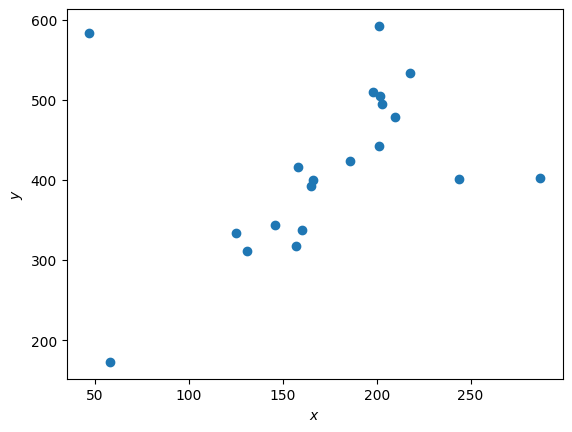

In [6]:
data = genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')

train_X = jnp.array(data['x'])
train_Y = jnp.array(data['y'])

n_samples = train_X.shape[0]
plt.scatter(train_X, train_Y)
plt.xlabel('$x$')
plt.ylabel('$y$');

Let's reshape:

In [7]:
X = data['x'].reshape(-1, 1)
y = data['y'].reshape(-1, 1)
X_tst = jnp.linspace(X.min(), X.max(), 100).reshape(-1, 1)

To replicate linear regression we just need a single dense layer with a single output.  We'll use the `flax.nn` module to define our model.

In [8]:
# We create one dense layer instance, where 'features' sets the output dimension
model = nn.Dense(features=1)

The models don't actually store the parameters, so we need to initialize them with the `init` method.  We'll use the `jax.random.PRNGKey` to seed the random number generator as we have before.

In [9]:
key1, key2 = random.split(random.PRNGKey(0)) # random keys
params = model.init(key2, X[0])       # provide an example input so it can infer the shapes
params

{'params': {'kernel': Array([[2.1127698]], dtype=float32),
  'bias': Array([0.], dtype=float32)}}

We can see that `params` has a kernel (i.e., weights, or slope in this case) and bias (y-intercept), initialized to random and zero values, respectively.

If we want to compute a forward pass of our model (i.e., plug in a `x` value and get a predicted `y` value), we can use the `apply` method.  Remember the parameters (slope and y-intercept) aren't stored in the model, so we need to provide them.

In [10]:
model.apply(params, X[0]) # example application of the model

Array([424.66675], dtype=float32)

## Cost Function

Recall that performing linear regression is equivalent to minimizing the mean squared error (MSE) between the model predictions and the data.

We're going to minimize the MSE using gradient descent, and we'll write everything from scratch as an excuse to learn how to use `Flax`.

First the cost function.  We're going to have `JAX` do some optimization with just-in-time (JIT) compiling (see [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions) for gorier details).

In [11]:
@jax.jit
def mse(params, x_batched, y_batched):
    # the squared loss for a single (x, y) pair
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y - pred, y - pred)/2.0
    # vectorize this to compute the averae loss over a batch of data
    return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched), axis=0)

In [12]:
mse(params, X, y)

Array(9112.817, dtype=float32)

In [13]:
%timeit mse(params, X, y)

21.8 μs ± 803 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


It works, and it's fast!  Try commenting out the `@jax.jit` decorator and rerun the two cells above to compare run times.

## Gradient Decent

Recall the algorithm for gradient decent:
$$
\mathrm{repeat~until~convergence} \{\\
\theta_j = \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta_0, \theta_1) \mathrm{~~~~for~}j=0\mathrm{~and~}j=1
\\\}
$$

where $\alpha$ is the *learning rate*.

Remember that one of `JAX`'s superpowers is that it can automatically compute gradients of functions.  `jax.value_and_grad()` will give us a function that computes the value and gradient of our MSE cost function for us.

In [14]:
loss_grad_fn = jax.value_and_grad(mse)
loss_grad_fn(params, X, y)

(Array(9112.817, dtype=float32),
 {'params': {'bias': Array([-53.6239], dtype=float32),
   'kernel': Array([[-4828.3003]], dtype=float32)}})

Let's use it to update parameters during gradient decent.

In [15]:
learning_rate = 0.00001 # Gradient descent step size

@jax.jit
def update_params(params, learning_rate, grads):
    params = jax.tree_util.tree_map(
        lambda p, g: p - learning_rate * g, params, grads)
    return params

...and finally put it all together:

In [16]:
loss_vals = []
for step in range(100):
    loss_val, grads = loss_grad_fn(params, X, y)
    params = update_params(params, learning_rate, grads)
    if step % 10 == 0: # print every 10 steps
        print(f"Step {step}, loss {loss_val}")
    loss_vals.append(loss_val)

Step 0, loss 9112.8173828125
Step 10, loss 8759.513671875
Step 20, loss 8759.3154296875
Step 30, loss 8759.2353515625
Step 40, loss 8759.15625
Step 50, loss 8759.0771484375
Step 60, loss 8758.9951171875
Step 70, loss 8758.9150390625
Step 80, loss 8758.8349609375
Step 90, loss 8758.7548828125


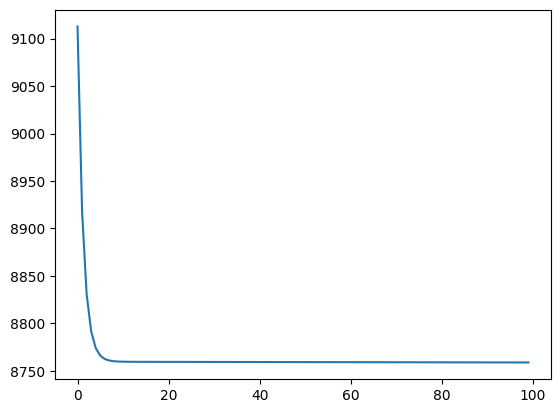

In [17]:
plt.plot(loss_vals);

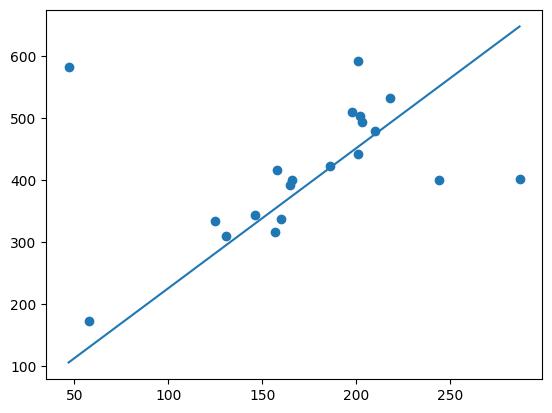

In [18]:
plt.scatter(X, y)
plt.plot(X_tst, model.apply(params, X_tst));

## Fancier Optimization


In [19]:
import optax
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(mse)

In [20]:
for i in range(101):
  loss_val, grads = loss_grad_fn(params, X, y)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)


Loss step 0:  8758.677
Loss step 10:  8758.673
Loss step 20:  8758.67
Loss step 30:  8758.667
Loss step 40:  8758.664
Loss step 50:  8758.661
Loss step 60:  8758.659
Loss step 70:  8758.655
Loss step 80:  8758.652
Loss step 90:  8758.651
Loss step 100:  8758.648
